In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from time import time
import keras.backend as K
from keras.layers import Dense, Input, Embedding, Layer, InputSpec
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from sklearn.manifold import TSNE
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import random
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
df = pd.read_csv("/content/netflix_titles.csv")

In [2]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [4]:
df=df.dropna()

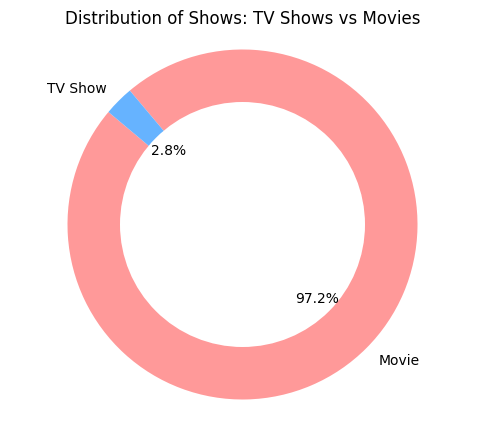

In [5]:
show_counts = df['type'].value_counts()
labels = show_counts.index
sizes = show_counts.values

colors = ['#ff9999', '#66b3ff']

fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.4}, colors=colors)
ax.axis('equal')


center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(center_circle)

plt.title('Distribution of Shows: TV Shows vs Movies')
plt.show()

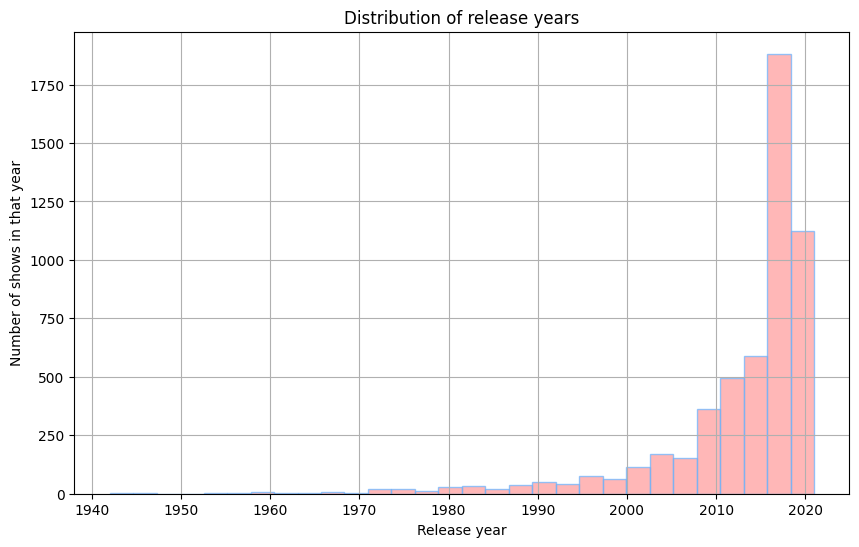

In [6]:
mean_release_year = df['release_year'].mean()
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(10, 6))

plt.hist(df['release_year'], bins=30, edgecolor=colors[1], alpha=0.7, color=colors[0])
plt.xlabel('Release year')
plt.ylabel('Number of shows in that year')

plt.title('Distribution of release years')
plt.grid(True)

plt.show()

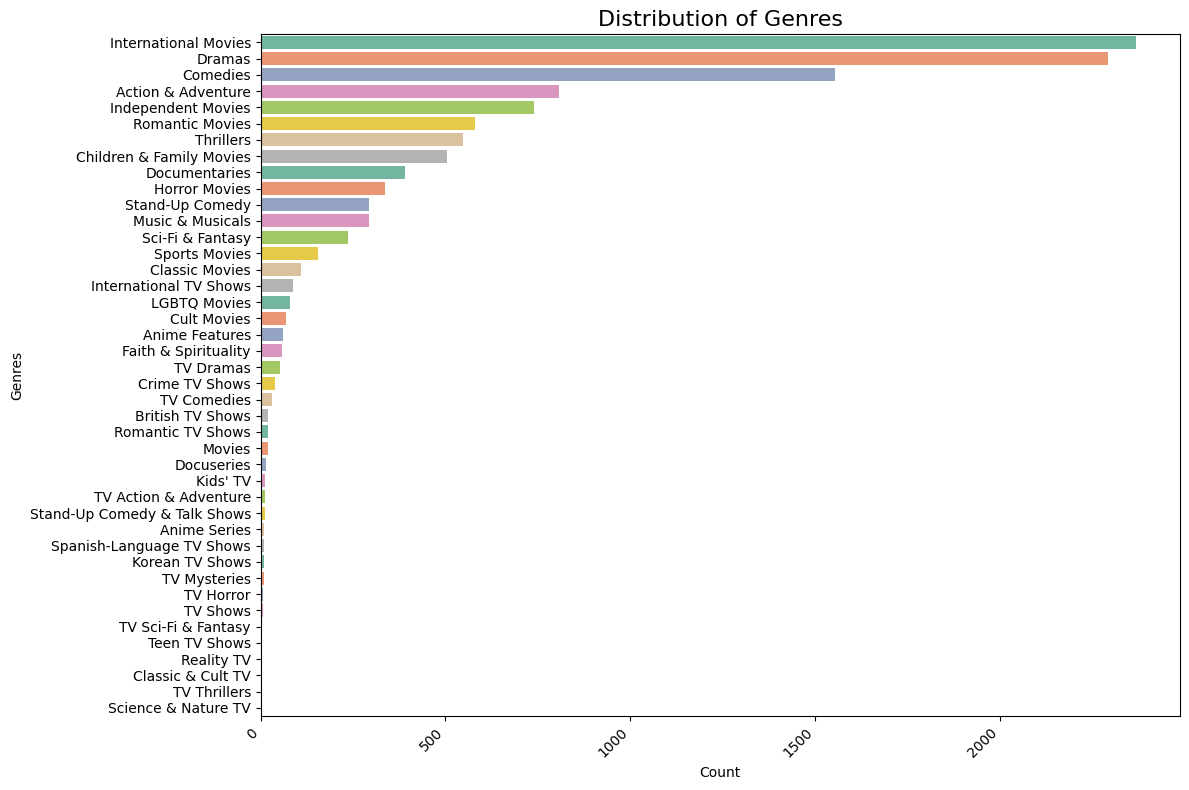

In [7]:
df['genres'] = df['listed_in'].apply(lambda x: x.split(', ')) #virgülden ayırıp listeye atyıoruz
all_genres = [genre for sublist in df['genres'] for genre in sublist]#virgülden ayırıp listeye atyıoruz

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 8))

# Renk paleti
colors = sns.color_palette('Set2')

# Çubuk grafik oluşturma
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette=colors)

plt.xlabel('Count')
plt.ylabel('Genres')
plt.title('Distribution of Genres', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Etiketlerin dönme ve hizalamasını ayarlama
plt.tight_layout()

plt.show()

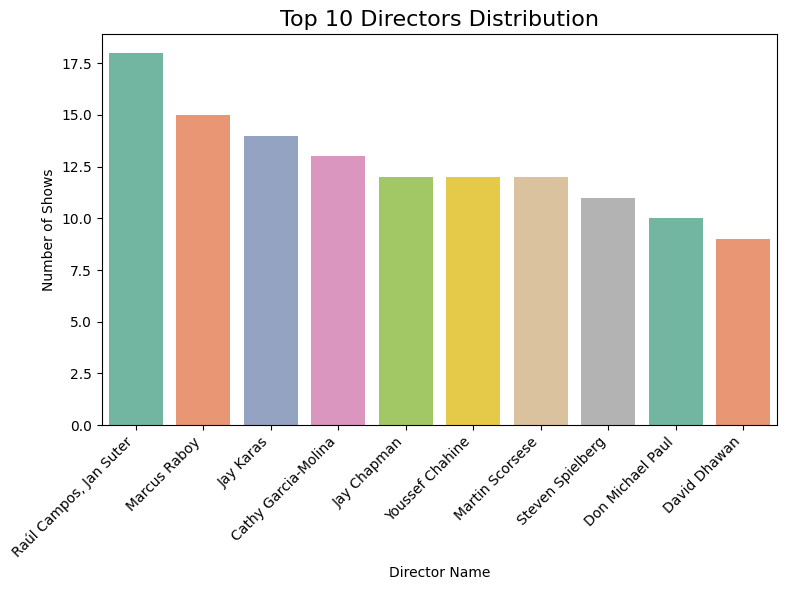

In [8]:
directors = df.groupby('director').size() #gruplayıp countluyoruz
top_dir = directors.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))

colors = sns.color_palette('Set2')

sns.barplot(x=top_dir.index, y=top_dir.values, palette=colors)

plt.xlabel('Director Name')
plt.ylabel('Number of Shows')
plt.title('Top 10 Directors Distribution', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Etiketlerin dönme ve hizalamasını ayarlama
plt.tight_layout()  # Otomatik olarak alt grafik parametrelerini belirtilen yastıklamayı sağlamak için ayarlar

plt.show()


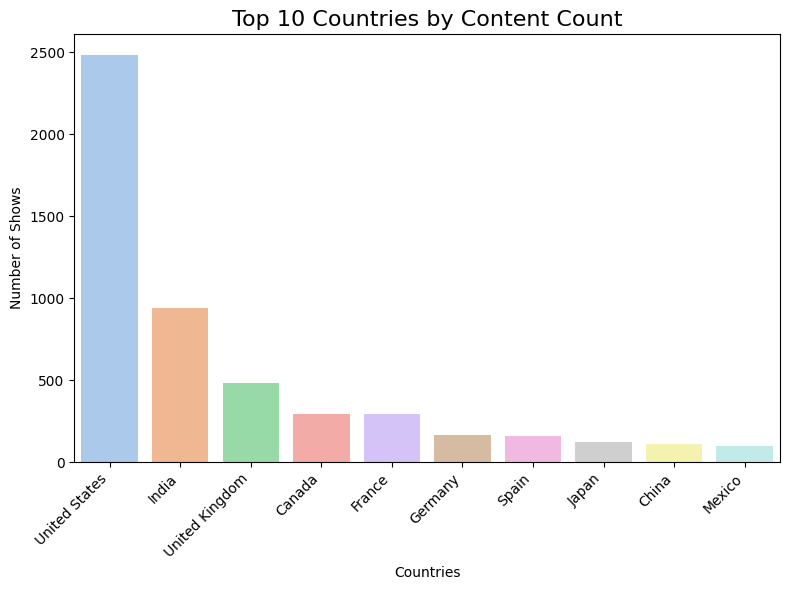

In [9]:
df['countries'] = df['country'].apply(lambda x: x.split(', '))#virgülden ayırıp listeye atyıoruz
all_countries = [country for sublist in df['countries'] for country in sublist]#virgülden ayırıp listeye atyıoruz
country_counts = pd.Series(all_countries).value_counts().head(10)

plt.figure(figsize=(8, 6))

colors = sns.color_palette('pastel')

sns.barplot(x=country_counts.index, y=country_counts.values, palette=colors)

plt.xlabel('Countries')
plt.ylabel('Number of Shows')
plt.title('Top 10 Countries by Content Count', fontsize=16)  # Başlık boyutunu büyütme
plt.xticks(rotation=45, ha='right', fontsize=10)  # Etiketlerin dönme ve hizalamasını ayarlama
plt.tight_layout()  # Otomatik olarak alt grafik parametrelerini belirtilen yastıklamayı sağlamak için ayarlar

plt.show()

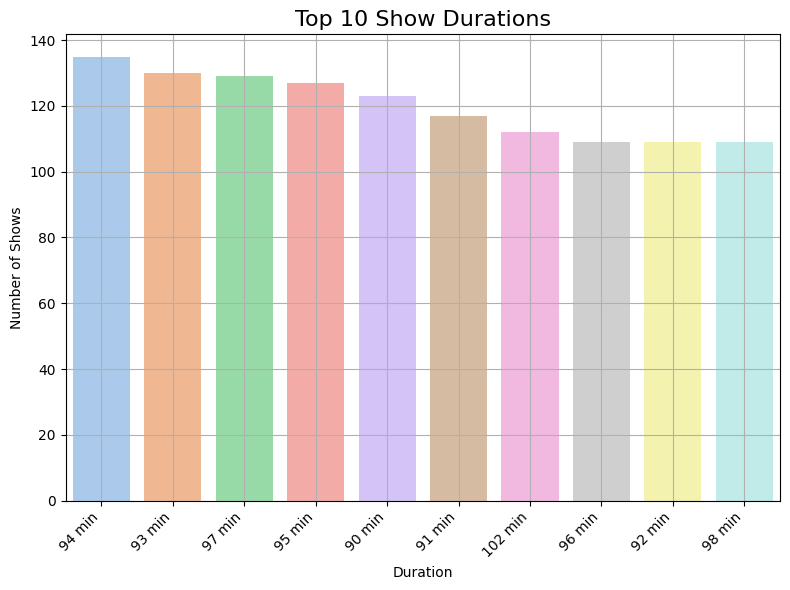

In [10]:
show_duration = df['duration'].value_counts().head(10)

plt.figure(figsize=(8, 6))

colors = sns.color_palette('pastel')

sns.barplot(x=show_duration.index, y=show_duration.values, palette=colors)

plt.xlabel('Duration')
plt.ylabel('Number of Shows')
plt.title('Top 10 Show Durations', fontsize=16)  # Başlık boyutunu büyütme
plt.xticks(rotation=45, ha='right', fontsize=10)  # Etiketlerin dönme ve hizalamasını ayarlama
plt.grid(True)
plt.tight_layout()

plt.show()

In [11]:
df=df.drop(["genres","countries"],axis=1)

## Topic Modelling

###CountVectorizer metin verilerini işlemek için kullanılır.
###max_df ile bir kelimenin en fazla ne kadar belgede görünmesine izin verileceğini belirleyebilirsiniz.
###min_df ile bir kelimenin en az ne kadar belgede görünmesi gerektiğini belirleyebilirsiniz.
###stop_words ile İngilizce stop kelimelerini kullanabilirsiniz.

In [12]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [13]:
dtm = cv.fit_transform(df['description'])

###Ardından, bu DTM kullanılarak bir LDA (Latent Dirichlet Allocation) modeli oluşturulur.

###n_components LDA modelinin kaç konu keşfedeceğini belirler.


In [14]:
LDA = LatentDirichletAllocation(n_components=5,random_state=42)

In [15]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [16]:
len(list(cv.get_feature_names_out()))

7329

###Rastgele bir kelime seçmek için bir döngü kullanılır. random.randint(0, 7329) ile 0 ile 7329 (DTM'deki kelime sayısı) arasında rastgele 10 kelime seçilir ve bu kelimeler yazdırılır.



In [17]:
for i in range(10):
    random_word_id = random.randint(0,7329)
    print(list(cv.get_feature_names_out())[random_word_id])

strikes
chef
rampage
devastating
honey
modernize
dhabi
weary
pharmaceutical
value


###İlk konunun en çok kullanılan kelimeleri yazdırılır.

###Her bir konu için LDA.components_ kullanılır. Bu, her kelimenin her konudaki ağırlığını içeren bir matristir.  Bu matristeki kelimelerin endeksleri, en çok kullanılan kelimeleri belirlemek için sıralanır ve bu kelimeler yazdırılır.

In [18]:
single_topic = LDA.components_[0]
top_word_indices = single_topic.argsort()[-15:]
for index in top_word_indices:
    print(list(cv.get_feature_names_out())[index])

school
york
teen
love
finds
father
world
city
group
takes
man
family
new
young
life


###Her bir konunun en iyi 15 kelimesi yazdırılır.

###LDA.components_ kullanılarak her bir konu için aynı işlem tekrarlanır. Her konunun en çok kullanılan 15 kelimesi yazdırılır

In [19]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([list(cv.get_feature_names_out())[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['school', 'york', 'teen', 'love', 'finds', 'father', 'world', 'city', 'group', 'takes', 'man', 'family', 'new', 'young', 'life']


THE TOP 15 WORDS FOR TOPIC #1
['bond', 'friend', 'special', 'comedian', 'finds', 'years', 'son', 'childhood', 'new', 'world', 'young', 'love', 'documentary', 'life', 'woman']


THE TOP 15 WORDS FOR TOPIC #2
['help', 'home', 'love', 'father', 'mysterious', 'high', 'gets', 'woman', 'finds', 'friends', 'town', 'school', 'young', 'man', 'new']


THE TOP 15 WORDS FOR TOPIC #3
['father', 'film', 'life', 'true', 'wife', 'based', 'woman', 'home', 'man', 'couple', 'love', 'world', 'new', 'family', 'young']


THE TOP 15 WORDS FOR TOPIC #4
['special', 'time', 'old', 'daughter', 'girl', 'new', 'woman', 'father', 'mother', 'brother', 'help', 'young', 'family', 'man', 'life']




###Son olarak, LDA.transform() kullanılarak her belgenin hangi konu ile ilişkilendirildiği tahmin edilir.

###Bu tahminler, "Topic" adlı yeni bir sütuna eklenir.

In [20]:
topic_results = LDA.transform(dtm)
df["Topic"]=topic_results.argmax(axis=1)

In [21]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,Topic
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",0
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...,2
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...,1
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...,3
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...,4


#Recommendation Systems

###TF-IDF (Terim Frekansı - Ters Belge Sıklığı) vektörizasyonu, metin verilerini sayısal vektörlere dönüştürmek için kullanılan bir tekniktir.

###Terim Frekansı (TF): Bir belgedeki her terimin belge içinde ne kadar sık göründüğünü ölçen bir değerdir.

###Ters Belge Sıklığı (IDF): Bir terimin ne kadar yaygın veya nadir olduğunu hesaplamak için kullanılan bir değerdir

###TF-IDF Skoru: Bir terimin belge içindeki sıklığını (TF) ters belge sıklığı (IDF) ile çarptığınızda elde edilen bir sayıdır. Bu skor, bir terimin belge içindeki önemini ölçer.

In [22]:
tfidf = TfidfVectorizer(stop_words="english")

In [23]:
tfidf_matrix = tfidf.fit_transform(df['description'])

### cosine_similarity işlevi, belge benzerliği(title - description) matrisini hesaplar. Her iki belge arasındaki kosinüs benzerliği, belgelerin birbirine ne kadar benzer olduğunu ölçer.
###Bir indeks Serisi oluşturulur, bu indeks metinlerin başlıklarını ve indekslerini içerir. Ardından, "Sankofa" adlı belgenin(title) indeksi alınır

In [24]:
cosine_sim = cosine_similarity(tfidf_matrix,
                               tfidf_matrix)
indices = pd.Series(df.index, index=df['title'])

indices = indices[~indices.index.duplicated(keep="first")]


###Belgenin diğer belgelerle benzerlik skorları hesaplanır
###"Sankofa" belgesi ile diğer tüm belgeler arasındaki benzerlik skorları alınır ve sıralanır.
###Son olarak, en benzer belgeler ve bu belgelerin benzerlik skorları bir tabloda görüntülenir:

In [25]:
nf = indices["Sankofa"]

similarity_scores = pd.DataFrame(cosine_sim[nf], columns=["score"])

nf = similarity_scores.sort_values("score", ascending=False)[1:11].index

similar_texts = df[['title', 'description']].iloc[nf]
similar_texts.reset_index(drop=True, inplace=True)
similar_texts['score'] = similarity_scores.sort_values("score", ascending=False)[1:11].values
display(similar_texts)

,title,description,score
0,The Arbitration,An arbitration panel is formed after a company...,0.237244
1,Manorama Six Feet Under,A government employee and aspiring crime write...,0.212391
2,First Kiss,A starry-eyed employee of a hot cosmetics comp...,0.203348
3,Ex Machina,A coder at a tech company wins a week-long ret...,0.201680
4,Master,Needing hard evidence to convict a company cha...,0.165055
5,Mean Streets,"In New York's Little Italy, a low-level hoodlu...",0.153134
6,Cardboard Gangsters,A low-level drug dealer decides to move up the...,0.152354
7,Uriyadi 2,When a chemical plant's poor conditions cause ...,0.148365
8,Killing Them Softly,When a couple of low-level crooks rob a Mob-pr...,0.148333
9,The Promise,When his powerful crime czar boss kills the ma...,0.147998


# Clustering

In [26]:
df_token = df[ "description"]

maxlen = 1500                   # Her bir metni temsil edecek maksimum kelime sayısını belirtir.
training_samples = 800          # Eğitim örneklerinin sayısını belirtir.
validation_samples = 450        # Doğrulama (validation) örneklerinin sayısını belirtir.
max_words = 10000               # Veri kümesinde kullanılacak maksimum kelime sayısını belirtir.

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_token)                            # Metin verilerini kelimelere böler, her kelimenin indeksini belirler Apple 5, Orage 10 gibi
sequences = tokenizer.texts_to_sequences(df_token)          # Metinleri tam sayı dizilimlerine dönüştürür
word_index = tokenizer.word_index                           # Metinde bulunan her kelimenin indeksini içerir.
print(f"{len(word_index)} unique tokens found")

data = pad_sequences(sequences, maxlen=maxlen)              # Tüm tam sayı dizilimleri aynı uzunluğa (maksimum kelime sayısı) getirilir:
scaler = MinMaxScaler()
x = scaler.fit_transform(data)

15229 unique tokens found


In [27]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.



  dims: Encoder katmanlarının boyutlarını içeren bir liste, örneğin [500, 500, 2000, 10].
  dims[0] giriş boyutunu temsil eder, dims[-1] ise latent gizli katmanın boyutudur.

  act: Aktivasyon fonksiyonu

  return:
 (autoencoder_model, encoder_model): Otokodlayıcı modeli ve kodlayıcı modeli"
    """

    #Ardışık olarak bir veya daha fazla kodlayıcı(encoder) katmanı eklenir. Her kodlayıcı katmanı, giriş verisini daha düşük boyutlu bir temsile (latent temsil) dönüştürmeye çalışır.

    #Her kodlayıcı(encoder) katmanı, özelliklerin çeşitli dönüşümlerini uygulayarak veriyi sıkıştırır. Bu, önemli özelliklerin vurgulanmasını sağlar.

    n_stacks = len(dims) - 1   # Bu satır, n_stacks adında bir değişken oluşturur ve bu değişken, kodlayıcı katmanlarının sayısını belirlemek için kullanılır.
                               #dims listesindeki eleman sayısından 1 çıkararak elde edilir. dims listesi, otomatik kodlayıcı modelinin katman boyutlarını belirtir.


    input_data = Input(shape=(dims[0],), name='input')     #Input sınıfı, Keras kütüphanesinden gelir ve bir giriş katmanı oluşturmak için kullanılır.
    x = input_data                                         #shape=(dims[0],) ile giriş katmanının boyutu belirtilir



    # internal layers of encoder

    #Bu döngü, kodlayıcı katmanlarını oluşturur ve her bir katmanın girişi bir önceki katmanın çıkışıdır.
    #Bu şekilde veri, her katmandan geçerken sıkıştırılır ve daha düşük boyutlu bir temsil oluşturulur.
    #Bu kodlayıcı katmanları, verinin önemli özelliklerini vurgulayarak veriyi daha düşük boyutlu bir uzayda temsil etmeye çalışır.

    for i in range(n_stacks-1):                                                                     #
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)
    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)


    #Bu kod parçası, otomatik kodlayıcı modelinin bir sıkıştırma (encoder) ve ardından bir açma (decoder) işlemi gerçekleştirdiği kısmı içerir.
    #Kodlayıcı katmanları veriyi sıkıştırırken, çözücü katmanları sıkıştırılmış temsili orijinal boyutlarına geri döndürmeye çalışır.
    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)


    # decoder output
    #Bu kod parçası, otomatik kodlayıcı modelini oluşturur ve bu modeli kullanarak verinin sıkıştırılması ve orijinal boyutlarına geri dönüştürülmesi işlemlerini gerçekleştirir.

    #Ayrıca, sadece sıkıştırılmış temsilin elde edildiği bir kodlayıcı modelini de döndürür.
    #Bu, veriyi daha düşük boyutlu bir temsilde temsil etmek ve veriyi sıkıştırma işlemleri için kullanılabilir.

    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)

    decoded = x

    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')

    return autoencoder_model, encoder_model

In [28]:
n_clusters = 20 # Maksimum Cluster Sayısı
n_epochs   = 8 # Autoencoder için epoch sayısı
batch_size = 128 #Bu değişken, eğitim verilerinin kaçarlı gruplar halinde  modele sunulacağını belirtir.

**dims** = [x.shape[-1], 500, 500, 1000, 10]: Bu liste, otomatik kodlayıcı modelinin katmanlarının boyutlarını belirtir. Özellikle, bu modelin giriş katmanının boyutu x.shape[-1] ile başlar (giriş verisinin boyutuna uyar), ardından sırasıyla 500, 500, 1000 ve 10 nöron içeren gizli katmanlar gelir. Bu, otomatik kodlayıcı modelinin katmanlarının mimarisini tanımlar.

**pretrain_optimizer**= "rmsprop": Bu değişken, otomatik kodlayıcı modelinin ön eğitim (pretraining) sürecinde kullanılacak olan optimize edici (optimizer) yöntemini belirtir. "rmsprop" olarak belirtilmiş, bu, otomatik kodlayıcının ağırlıklarının başlangıç değerlerini ayarlayan bir ön eğitim süreci için kullanılabilecek bir optimize edici yöntemdir.

In [29]:
dims = [x.shape[-1], 500, 500, 1000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',    # VarianceScaling, ağırlıkların başlatılmasını kontrol eden bir başlatma stratejisidir.
                           distribution='uniform')      # Scale=1. / 3. ile başlangıç değerlerinin ölçeği belirtilir, mode='fan_in' ile mod seçilir
                                                        # Ve distribution='uniform' ile ağırlıkların başlatılma dağılımı belirtilir.
pretrain_optimizer = "rmsprop" #SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size

In [30]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)   # __init__ : Bu , katmanın başlatılmasını ve temel ayarlarını yapar. Özellikle, aşağıdaki parametreleri alır:
        super(ClusteringLayer, self).__init__(**kwargs)          # n_clusters: Küme sayısı. Yani, her bir örnek için ait olabileceği küme sayısı.
        self.n_clusters = n_clusters                             # İlk ağırlıklar. Bu, küme merkezlerinin başlangıç ağırlıklarını belirtir (varsayılan olarak None).
        self.alpha = alpha                                       # alpha: Student's t-distribution hesaplama işlemi sırasında kullanılan hiperparametre. Bu, olasılık hesaplamalarında kullanılır.
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):                                # build : Bu , katmanın inşa edilmesini sağlar. İlgili giriş şekli ve ağırlıkların başlatılması gibi ayarları gerçekleştirir.
        assert len(input_shape) == 2                             # Ayrıca, küme merkezlerini temsil eden ağırlıkları tanımlar.
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform')

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):                                                          # call: Bu , verileri giriş olarak alır ve
        '''                                                                                      Student's t-distribution, verinin kümelere atanma olasılıklarını hesaplamak için kullanılır.
        student t-distribution, as used in t-SNE algorithm.                                      Bu olasılıklar yumuşak etiketler olarak ifade edilir.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)

        inputs: the variable containing data, shape=(n_samples, n_features)

        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))

        return q

    def compute_output_shape(self, input_shape):                      # compute_output_shape : Bu , çıkış şeklinin nasıl hesaplanacağını belirtir.
        assert input_shape and len(input_shape) == 2                  # İlgili giriş şekli ve çıkışın her bir küme ile ilişkisini temsil eden boyutlar içerir.
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()        # get_config: Bu, katmanın yapılandırma ayarlarını döndürür.
        return dict(list(base_config.items()) + list(config.items()))  # Bu, modelin kaydedilmesi ve yeniden yüklenmesi sırasında kullanılabilir.

####Bu adımlar sonucunda, otomatik kodlayıcı modeli verinin sıkıştırılmış temsillerini oluşturur.
####Encoder kısmı, bu temsilleri sağlar ve decoder kısmı ise sıkıştırılmış temsilleri orijinal veriye geri dönüştürür. Bu şekilde, verinin temsilini öğrenen ve sıkıştıran bir otomatik kodlayıcı elde edilir.

In [31]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.compile(optimizer=pretrain_optimizer, loss='binary_crossentropy')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/8
42/42 [==============================] - 5s 92ms/step - loss: 0.0087
Epoch 2/8
42/42 [==============================] - 3s 74ms/step - loss: 0.0071
Epoch 3/8
42/42 [==============================] - 3s 69ms/step - loss: 0.0068
Epoch 4/8
42/42 [==============================] - 3s 69ms/step - loss: 0.0068
Epoch 5/8
42/42 [==============================] - 4s 87ms/step - loss: 0.0067
Epoch 6/8
42/42 [==============================] - 3s 80ms/step - loss: 0.0067
Epoch 7/8
42/42 [==============================] - 3s 69ms/step - loss: 0.0067
Epoch 8/8
42/42 [==============================] - 3s 71ms/step - loss: 0.0067


####Aşağıdaki adımlar sonucunda, verinin otomatik kodlayıcı tarafından temsil edilmesi ve ardından kümelere atanması için kullanılan bir model elde edilir.
####Bu model, veriyi sıkıştırıp kümelere atamak için kullanılır ve bu sayede verinin kümeleme işlemi gerçekleştirilir.

In [32]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [33]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

167/167 [==============================] - 1s 7ms/step


#### Aşağıdaki kod parçası, bir yardımcı hedef dağılımını hesaplamak için kullanılır. Yardımcı hedef dağılımı, otomatik kodlayıcı ve kümeleme işlemi sırasında kullanılır.

In [34]:
def target_distribution(q):                     # q,her bir küme ile ilişkisini temsil eden bir olasılık dağılımıdır
    weight = q ** 2 / q.sum(0)                  # Her bir örneğin her bir kümeye ait olma olasılıklarının karesini alır. Ardından, her kümeye ait olma olasılıklarının toplamını hesaplar
    return (weight.T / weight.sum(1)).T         # Weight matrisini normalize eder.

####Aşağıdaki kod parçası, bir kümeleme modelinin eğitilmesini gösterir ve K-Means kümeleme modeli ile çıktıların iyileştirilmesi için kullanılır

In [35]:
loss = 0                  # Başlangıçta kayıp (loss) sıfırlanır. Bu değişken, her iterasyonun sonunda toplam kaybı hesaplamak için kullanılır.
index = 0                 # İlk olarak, bir indeks değişkeni index sıfırlanır. Bu değişken, veri örneklerinin toplu halde işlenmesi sırasında kullanılır
maxiter = 1000            # Eğitimin maksimum iterasyon sayısı belirlenir. Eğitim, bu iterasyon sayısına ulaşana kadar devam eder.
update_interval = 100     # Yardımcı hedef dağılımını (p) güncellemek için kaç iterasyonda bir yapılacağını belirler. Yani, her 100 iterasyonda bir yardımcı hedef dağılımı yeniden hesaplanır.
index_array = np.arange(x.shape[0])
tol = 0.001               # Eğitimin erken durdurulması için bir tolerans eşik değeri



for ite in range(int(maxiter)):
  """
  a. Eğer ite % update_interval == 0 ise, q adlı bir değişkene model tarafından tahmin edilen sıkıştırılmış temsilleri alır (model.predict(x))
   ve ardından bu tahminlerden yardımcı hedef dağılımı p'yi günceller (p = target_distribution(q)).

  b. İndeks aralığını belirler ve veri örneklerini bu aralıkta alır (idx).

  c. Toplu işleme (mini-batch) yöntemi kullanarak modeli eğitir. Veriyi (x[idx]) ve hedef dağılımı (p[idx]) kullanarak modelin ağırlıklarını günceller ve kaybı hesaplar
   (loss = model.train_on_batch(x=x[idx], y=p[idx]).

  d. İndeks değişkenini günceller. Eğer bir toplu işleme sona erdiyse (yani, (index + 1) * batch_size toplam veri sayısına ulaştıysa), indeksi sıfırlar; aksi takdirde indeksi bir artırır.

  e. Her iterasyon sonunda toplam kaybı loss değişkenine ekler.

  Eğitim, maksimum iterasyon sayısına (maxiter) veya kayıp değişiminin tolerans eşiğine (tol) ulaşılana kadar devam eder.

  """
  if ite % update_interval == 0:
    q = model.predict(x, verbose=0)
    p = target_distribution(q)  # update the auxiliary target distribution p

  idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
  loss = model.train_on_batch(x=x[idx], y=p[idx])
  index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0




In [36]:
q = model.predict(x, verbose=0)  # Eğitilen modeli kullanarak, verinin sıkıştırılmış temsillerini hesaplar. x verisi, model tarafından sıkıştırılarak q değişkenine kaydedilir.

p = target_distribution(q)       # q değerlerini kullanarak yardımcı hedef dağılımını (p) hesaplar. Bu dağılım, her bir örneğin her bir kümeye ait olma olasılığını içerir.

y_pred = q.argmax(1)             #q matrisindeki her bir satırı inceleyerek, her örneğin en yüksek olasılığa sahip olduğu küme indeksini (y_pred) belirler.
                                 #Yani, her bir örneği en olası kümesine atar.

In [37]:
all_df = df.copy()

In [38]:
all_df['cluster'] = y_pred
all_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,Topic,cluster
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",0,18
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...,2,9
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...,1,10
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...,3,14
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...,4,19
27,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,"September 20, 2021",2010,PG-13,103 min,Comedies,Mourning the loss of their beloved junior high...,0,8
28,s29,Movie,Dark Skies,Scott Stewart,"Keri Russell, Josh Hamilton, J.K. Simmons, Dak...",United States,"September 19, 2021",2013,PG-13,97 min,"Horror Movies, Sci-Fi & Fantasy",A family’s idyllic suburban life shatters when...,2,1
29,s30,Movie,Paranoia,Robert Luketic,"Liam Hemsworth, Gary Oldman, Amber Heard, Harr...","United States, India, France","September 19, 2021",2013,PG-13,106 min,Thrillers,"Blackmailed by his company's CEO, a low-level ...",3,1
38,s39,Movie,Birth of the Dragon,George Nolfi,"Billy Magnussen, Ron Yuan, Qu Jingjing, Terry ...","China, Canada, United States","September 16, 2021",2017,PG-13,96 min,"Action & Adventure, Dramas",A young Bruce Lee angers kung fu traditionalis...,2,9
41,s42,Movie,Jaws,Steven Spielberg,"Roy Scheider, Robert Shaw, Richard Dreyfuss, L...",United States,"September 16, 2021",1975,PG,124 min,"Action & Adventure, Classic Movies, Dramas",When an insatiable great white shark terrorize...,1,5


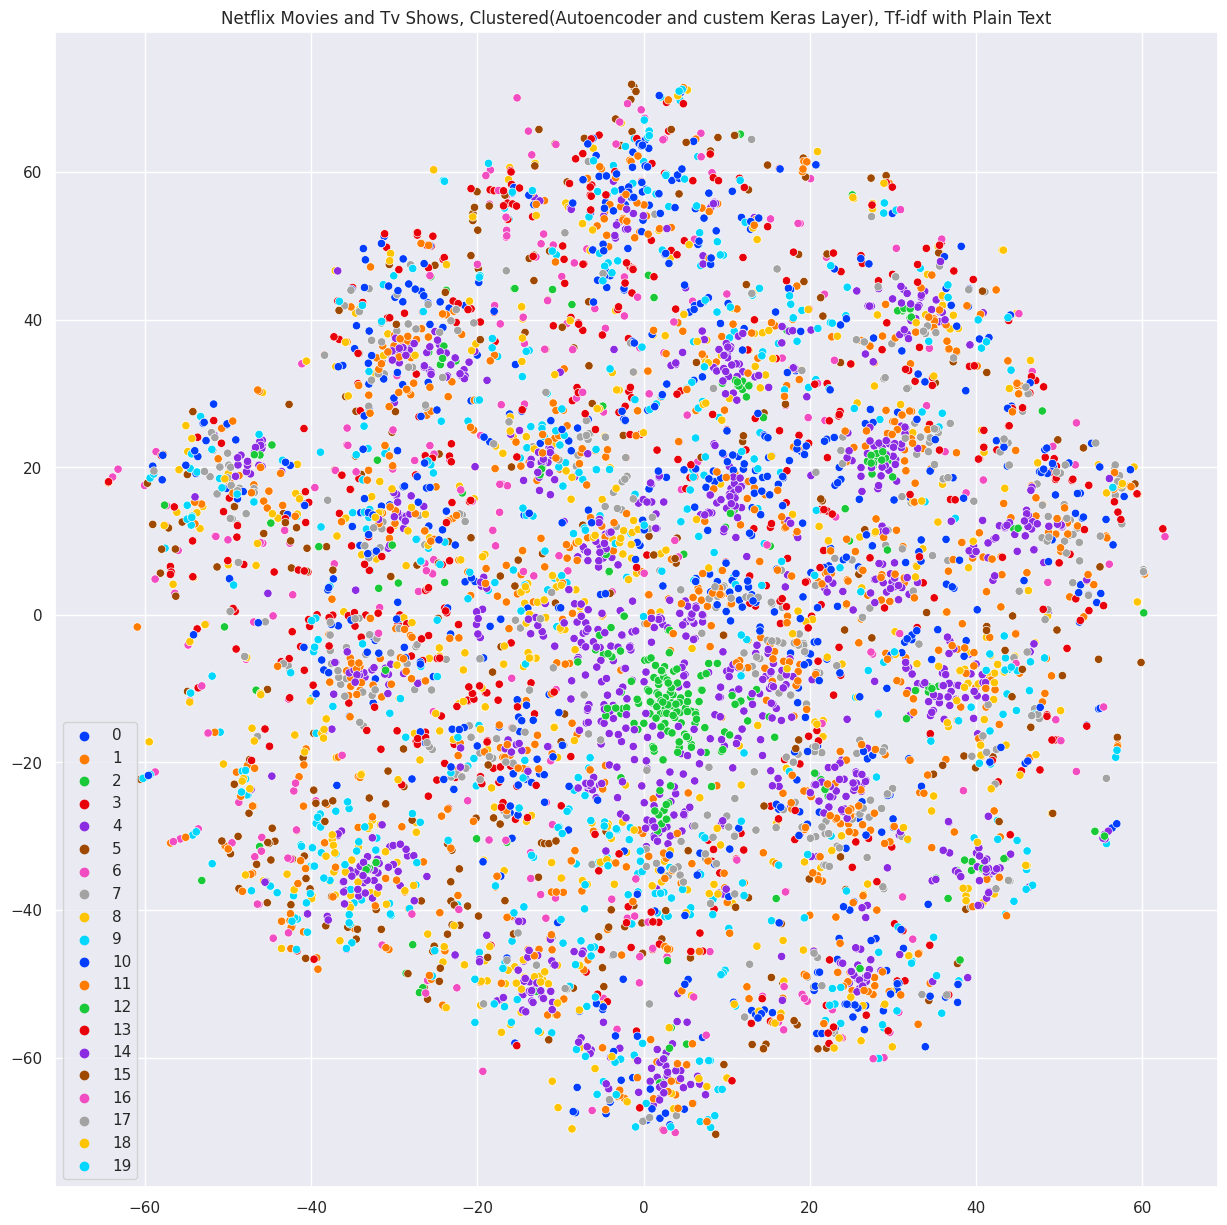

In [39]:
x_embedded = TSNE(n_components=2).fit_transform(x) # t-SNE kullanarak iki boyutlu bir uzaya dönüştürür. n_components=2, elde edilen görselleştirmenin iki boyutlu olmasını belirtir.

sns.set(rc={'figure.figsize':(15,15)})
palette = sns.color_palette("bright", len(set(y_pred)))# x_embedded[:,0] ve x_embedded[:,1], iki boyutlu uzayda örneklerin koordinatlarını temsil eder.
sns.scatterplot(x=x_embedded[:,0], y=x_embedded[:,1], hue=y_pred, palette=palette) #hue=y_pred ise, her örneğin hangi kümeye ait olduğunu belirtir ve bu nedenle farklı renklerle temsil edilir.
plt.title("Netflix Movies and Tv Shows, Clustered(Autoencoder and custem Keras Layer), Tf-idf with Plain Text")
plt.show()